In [1]:
import os
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# path of all csv files
csv_files = glob.glob(os.getcwd()+"*/*.csv")

In [3]:
len(csv_files)

169

In [4]:
from sklearn.model_selection import train_test_split

def datagen(paths, test_size=0.1):
    label_encoder = LabelEncoder()
    scaler = StandardScaler()

    for path in paths:
        df = pd.read_csv(path)

        # Labels and features extraction
        labels = df['label']
        features = df.iloc[:,:-1]

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size)

        # Labels and features pre-processing
        X_train = scaler.fit_transform(X_train)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
        y_train = label_encoder.fit_transform(y_train)
        y_train = to_categorical(y_train)

        X_test = scaler.transform(X_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
        y_test = label_encoder.transform(y_test)
        y_test = to_categorical(y_test)


        yield (X_train, y_train), (X_test, y_test)

In [4]:
# from sklearn.model_selection import train_test_split

# def datagen(paths, labels_to_pick, test_size=0.2):
#     label_encoder = LabelEncoder()
#     scaler = StandardScaler()

#     for path in paths:
#         df = pd.read_csv(path)

#         # Filter rows based on the labels you want to pick
#         df = df[df['label'].isin(labels_to_pick)]

#         # Labels and features extraction
#         labels = df['label']
#         features = df.iloc[:,:-1]

#         # Split the data into training and test sets
#         X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size)

#         # Labels and features pre-processing
#         X_train = scaler.fit_transform(X_train)
#         X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
#         y_train = label_encoder.fit_transform(y_train)
#         y_train = to_categorical(y_train)

#         X_test = scaler.transform(X_test)
#         X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
#         y_test = label_encoder.transform(y_test)
#         y_test = to_categorical(y_test)


#         yield (X_train, y_train), (X_test, y_test)

# # Define the list of class labels you want to pick

# labels_to_pick = {
#     'DDoS-ICMP_Flood': 'DDoS',
#     'DDoS-UDP_Flood': 'DDoS',
#     'DDoS-TCP_Flood': 'DDoS',
#     'DDoS-PSHACK_Flood': 'DDoS',
#     'DDoS-SYN_Flood': 'DDoS',
#     'DDoS-RSTFINFlood': 'DDoS',
#     'DDoS-SynonymousIP_Flood': 'DDoS',
#     'DDoS-UDP_Fragmentation': 'DDoS',
#     'DDoS-ACK_Fragmentation': 'DDoS',
#     'DDoS-ICMP_Fragmentation': 'DDoS',
#     'DDoS-HTTP_Flood': 'DDoS',
#     'DDoS-SlowLoris': 'DDoS',
    
#     'DoS-UDP_Flood' : 'DoS',
#     'DoS-TCP_Flood' : 'DoS',
#     'DoS-SYN_Flood' : 'DoS',
#     'DoS-HTTP_Flood': 'DoS'
# }

In [6]:
# define an object of custom dataloader

dataloader = datagen(csv_files)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

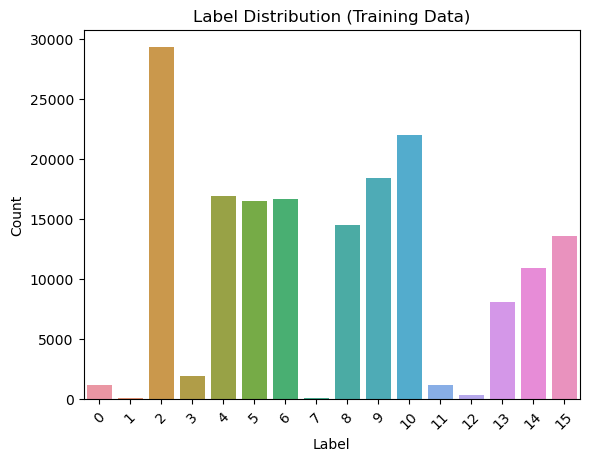

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you want to visualize the distribution of labels in the training data
(X_train, y_train), _ = next(dataloader)

# Convert the training labels to a pandas Series
labels = pd.Series(y_train.argmax(axis=1))

# Example: Bar chart to visualize the distribution of labels in the training data
sns.countplot(x=labels)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution (Training Data)')
plt.xticks(rotation=45)
plt.show()

In [10]:
# define your model
import keras
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

model = keras.Sequential()

model.add(Conv1D(32, 3, activation = 'relu', input_shape = (46,1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation = 'relu'))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'softmax'))

In [11]:
# compile your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Train the model for each batch
batch_size = 15

for i in tqdm(range(0, len(csv_files), batch_size)):
    print(f"Training Started on file number {i} to {i + batch_size - 1}")
    try:
        (X_train, y_train), (X_test, y_test) = next(iter(dataloader))
    except:
        pass
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

    # After training, make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert one-hot encoded labels back to class labels
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print()
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Training Started on file number 0 to 14
Epoch 1/10
2462/2462 [==============================] - 26s 10ms/step - loss: 0.1550 - accuracy: 0.9495 - val_loss: 0.0647 - val_accuracy: 0.9897
Epoch 2/10
2462/2462 [==============================] - 21s 9ms/step - loss: 0.0289 - accuracy: 0.9916 - val_loss: 0.0364 - val_accuracy: 0.9926
Epoch 3/10
2462/2462 [==============================] - 21s 9ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.0266 - val_accuracy: 0.9959
Epoch 4/10
2462/2462 [==============================] - 25s 10ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0854 - val_accuracy: 0.9960
Epoch 5/10
2462/2462 [==============================] - 24s 10ms/step - loss: 0.0179 - accuracy: 0.9966 - val_loss: 0.0770 - val_accuracy: 0.9958
Epoch 6/10
2462/2462 [==============================] - 19s 8ms/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0589 - val_accuracy: 0.9965
Epoch 7/10
2462/2462 [==============================] - 18s 7ms/step - loss: 0.0110 - a

  8%|██████▊                                                                           | 1/12 [03:36<39:39, 216.33s/it]


Precision: 0.9966, Recall: 0.9965, F1-score: 0.9965
Training Started on file number 15 to 29
Epoch 1/10
3103/3103 [==============================] - 23s 7ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0086 - val_accuracy: 0.9973
Epoch 2/10
3103/3103 [==============================] - 24s 8ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.0089 - val_accuracy: 0.9977
Epoch 3/10
3103/3103 [==============================] - 23s 8ms/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 4/10
3103/3103 [==============================] - 24s 8ms/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0073 - val_accuracy: 0.9978
Epoch 5/10
3103/3103 [==============================] - 57583s 19s/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 6/10
3103/3103 [==============================] - 41s 13ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0076 - val_accuracy: 0.9976
Epoch 7/10
3103/3103 [==========

 17%|████████████▎                                                             | 2/12 [16:07:40<94:45:49, 34114.92s/it]


Precision: 0.9983, Recall: 0.9983, F1-score: 0.9983
Training Started on file number 30 to 44
Epoch 1/10
2606/2606 [==============================] - 23s 9ms/step - loss: 0.0296 - accuracy: 0.9973 - val_loss: 0.0194 - val_accuracy: 0.9978
Epoch 2/10
2606/2606 [==============================] - 24s 9ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.0188 - val_accuracy: 0.9976
Epoch 3/10
2606/2606 [==============================] - 28s 11ms/step - loss: 0.0096 - accuracy: 0.9978 - val_loss: 0.0262 - val_accuracy: 0.9975
Epoch 4/10
2606/2606 [==============================] - 23s 9ms/step - loss: 0.0083 - accuracy: 0.9980 - val_loss: 0.0157 - val_accuracy: 0.9979
Epoch 5/10
2606/2606 [==============================] - 23s 9ms/step - loss: 0.0083 - accuracy: 0.9980 - val_loss: 0.0206 - val_accuracy: 0.9980
Epoch 6/10
2606/2606 [==============================] - 22s 9ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0229 - val_accuracy: 0.9977
Epoch 7/10
2606/2606 [=============

 25%|██████████████████▌                                                       | 3/12 [16:11:55<46:38:06, 18654.03s/it]


Precision: 0.9980, Recall: 0.9978, F1-score: 0.9978
Training Started on file number 45 to 59
Epoch 1/10
2564/2564 [==============================] - 24s 9ms/step - loss: 0.0111 - accuracy: 0.9977 - val_loss: 0.0094 - val_accuracy: 0.9981
Epoch 2/10
2564/2564 [==============================] - 26s 10ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.0131 - val_accuracy: 0.9979
Epoch 3/10
2564/2564 [==============================] - 25s 10ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0089 - val_accuracy: 0.9983
Epoch 4/10
2564/2564 [==============================] - 23s 9ms/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.0119 - val_accuracy: 0.9980
Epoch 5/10
2564/2564 [==============================] - 23s 9ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0128 - val_accuracy: 0.9978
Epoch 6/10
2564/2564 [==============================] - 24s 9ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0076 - val_accuracy: 0.9981
Epoch 7/10
2564/2564 [============

 33%|████████████████████████▋                                                 | 4/12 [16:16:00<25:18:09, 11386.25s/it]


Precision: 0.9980, Recall: 0.9978, F1-score: 0.9978
Training Started on file number 60 to 74
Epoch 1/10
2704/2704 [==============================] - 25s 9ms/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.0113 - val_accuracy: 0.9977
Epoch 2/10
2704/2704 [==============================] - 24s 9ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0166 - val_accuracy: 0.9975
Epoch 3/10
2704/2704 [==============================] - 26s 10ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0098 - val_accuracy: 0.9977
Epoch 4/10
2704/2704 [==============================] - 32s 12ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0124 - val_accuracy: 0.9974
Epoch 5/10
2704/2704 [==============================] - 35s 13ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0213 - val_accuracy: 0.9979
Epoch 6/10
2704/2704 [==============================] - 28s 10ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0196 - val_accuracy: 0.9978
Epoch 7/10
2704/2704 [==========

 42%|███████████████████████████████▎                                           | 5/12 [16:21:13<14:22:31, 7393.09s/it]


Precision: 0.9981, Recall: 0.9981, F1-score: 0.9981
Training Started on file number 75 to 89
Epoch 1/10
2635/2635 [==============================] - 25s 10ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 2/10
2635/2635 [==============================] - 24s 9ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 0.0063 - val_accuracy: 0.9982
Epoch 3/10
2635/2635 [==============================] - 22s 8ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0080 - val_accuracy: 0.9977
Epoch 4/10
2635/2635 [==============================] - 22s 8ms/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.0095 - val_accuracy: 0.9976
Epoch 5/10
2635/2635 [==============================] - 25s 10ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0082 - val_accuracy: 0.9981
Epoch 6/10
2635/2635 [==============================] - 24s 9ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0069 - val_accuracy: 0.9980
Epoch 7/10
2635/2635 [============

 50%|██████████████████████████████████████                                      | 6/12 [16:25:19<8:16:17, 4962.96s/it]


Precision: 0.9981, Recall: 0.9980, F1-score: 0.9981
Training Started on file number 90 to 104
Epoch 1/10
2568/2568 [==============================] - 26s 10ms/step - loss: 0.0136 - accuracy: 0.9980 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 2/10
2568/2568 [==============================] - 25s 10ms/step - loss: 0.0138 - accuracy: 0.9981 - val_loss: 0.0070 - val_accuracy: 0.9980
Epoch 3/10
2568/2568 [==============================] - 23s 9ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0059 - val_accuracy: 0.9981
Epoch 4/10
2568/2568 [==============================] - 23s 9ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0318 - val_accuracy: 0.9981
Epoch 5/10
2568/2568 [==============================] - 23s 9ms/step - loss: 0.0131 - accuracy: 0.9982 - val_loss: 0.0064 - val_accuracy: 0.9977
Epoch 6/10
2568/2568 [==============================] - 26s 10ms/step - loss: 0.0039 - accuracy: 0.9985 - val_loss: 0.0102 - val_accuracy: 0.9981
Epoch 7/10
2568/2568 [==========

 58%|████████████████████████████████████████████▎                               | 7/12 [16:29:25<4:45:04, 3420.88s/it]


Precision: 0.9978, Recall: 0.9979, F1-score: 0.9978
Training Started on file number 105 to 119
Epoch 1/10
2776/2776 [==============================] - 26s 9ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0072 - val_accuracy: 0.9980
Epoch 2/10
2776/2776 [==============================] - 26s 9ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0088 - val_accuracy: 0.9980
Epoch 3/10
2776/2776 [==============================] - 23s 8ms/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.0075 - val_accuracy: 0.9979
Epoch 4/10
2776/2776 [==============================] - 23s 8ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0067 - val_accuracy: 0.9981
Epoch 5/10
2776/2776 [==============================] - 23s 8ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0081 - val_accuracy: 0.9982
Epoch 6/10
2776/2776 [==============================] - 23s 8ms/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.0092 - val_accuracy: 0.9978
Epoch 7/10
2776/2776 [============

 67%|██████████████████████████████████████████████████▋                         | 8/12 [16:33:35<2:40:46, 2411.63s/it]


Precision: 0.9983, Recall: 0.9981, F1-score: 0.9982
Training Started on file number 120 to 134
Epoch 1/10
2564/2564 [==============================] - 21s 8ms/step - loss: 0.0148 - accuracy: 0.9979 - val_loss: 0.1107 - val_accuracy: 0.9976
Epoch 2/10
2564/2564 [==============================] - 21s 8ms/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.1351 - val_accuracy: 0.9978
Epoch 3/10
2564/2564 [==============================] - 21s 8ms/step - loss: 0.0093 - accuracy: 0.9982 - val_loss: 0.0486 - val_accuracy: 0.9980
Epoch 4/10
2564/2564 [==============================] - 22s 9ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0537 - val_accuracy: 0.9973
Epoch 5/10
2564/2564 [==============================] - 21s 8ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0667 - val_accuracy: 0.9975
Epoch 6/10
2564/2564 [==============================] - 21s 8ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0960 - val_accuracy: 0.9974
Epoch 7/10
2564/2564 [============

 75%|█████████████████████████████████████████████████████████                   | 9/12 [16:37:16<1:26:19, 1726.58s/it]


Precision: 0.9979, Recall: 0.9978, F1-score: 0.9978
Training Started on file number 135 to 149
Epoch 1/10
2831/2831 [==============================] - 23s 8ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 0.0326 - val_accuracy: 0.9979
Epoch 2/10
2831/2831 [==============================] - 23s 8ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0106 - val_accuracy: 0.9978
Epoch 3/10
2831/2831 [==============================] - 23s 8ms/step - loss: 0.0085 - accuracy: 0.9979 - val_loss: 0.0120 - val_accuracy: 0.9981
Epoch 4/10
2831/2831 [==============================] - 23s 8ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0178 - val_accuracy: 0.9982
Epoch 5/10
2831/2831 [==============================] - 23s 8ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 6/10
2831/2831 [==============================] - 23s 8ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0063 - val_accuracy: 0.9979
Epoch 7/10
2831/2831 [============

 83%|████████████████████████████████████████████████████████████████▏            | 10/12 [16:41:48<42:35, 1277.80s/it]


Precision: 0.9979, Recall: 0.9979, F1-score: 0.9979
Training Started on file number 150 to 164
Epoch 1/10
2501/2501 [==============================] - 23s 9ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.2394 - val_accuracy: 0.9980
Epoch 2/10
2501/2501 [==============================] - 22s 9ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.0067 - val_accuracy: 0.9985
Epoch 3/10
2501/2501 [==============================] - 21s 9ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0064 - val_accuracy: 0.9981
Epoch 4/10
2501/2501 [==============================] - 27s 11ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0164 - val_accuracy: 0.9979
Epoch 5/10
2501/2501 [==============================] - 31s 12ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.0345 - val_accuracy: 0.9980
Epoch 6/10
2501/2501 [==============================] - 25s 10ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.1185 - val_accuracy: 0.9984
Epoch 7/10
2501/2501 [=========

 92%|███████████████████████████████████████████████████████████████████████▌      | 11/12 [16:46:10<16:06, 966.69s/it]


Precision: 0.9979, Recall: 0.9979, F1-score: 0.9978
Training Started on file number 165 to 179
Epoch 1/10
2688/2688 [==============================] - 27s 10ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0094 - val_accuracy: 0.9979
Epoch 2/10
2688/2688 [==============================] - 27s 10ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0054 - val_accuracy: 0.9979
Epoch 3/10
2688/2688 [==============================] - 26s 10ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.0054 - val_accuracy: 0.9981
Epoch 4/10
2688/2688 [==============================] - 26s 10ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0069 - val_accuracy: 0.9981
Epoch 5/10
2688/2688 [==============================] - 23s 9ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0051 - val_accuracy: 0.9983
Epoch 6/10
2688/2688 [==============================] - 24s 9ms/step - loss: 0.0102 - accuracy: 0.9980 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 7/10
2688/2688 [========

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [16:50:33<00:00, 5052.75s/it]


Precision: 0.9980, Recall: 0.9978, F1-score: 0.9979


In [14]:
# Evaluate the model on the test set

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1344/1344 [==============================] - 4s 3ms/step - loss: 0.0164 - accuracy: 0.9978
Test Loss: 0.016449518501758575
Test Accuracy: 0.9978370070457458


In [15]:
# Evaluate the model on the test set

loss, accuracy = model.evaluate(X_train, y_train)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5375/5375 [==============================] - 17s 3ms/step - loss: 0.0103 - accuracy: 0.9981
Test Loss: 0.010268529877066612
Test Accuracy: 0.9980928301811218


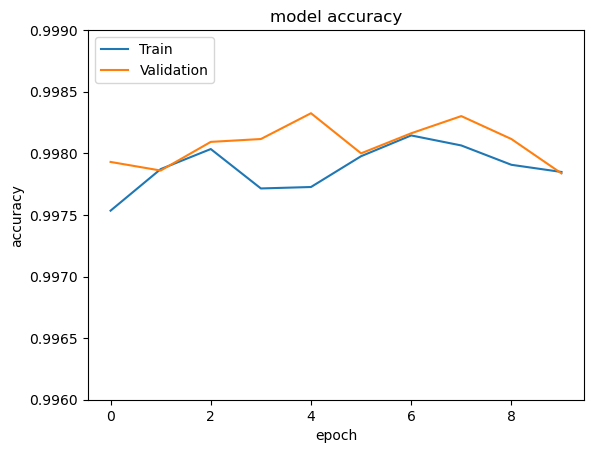

In [30]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.996, 0.999]) # Set the y-axis range from 0.9 to 1.0 (90% to 100%)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

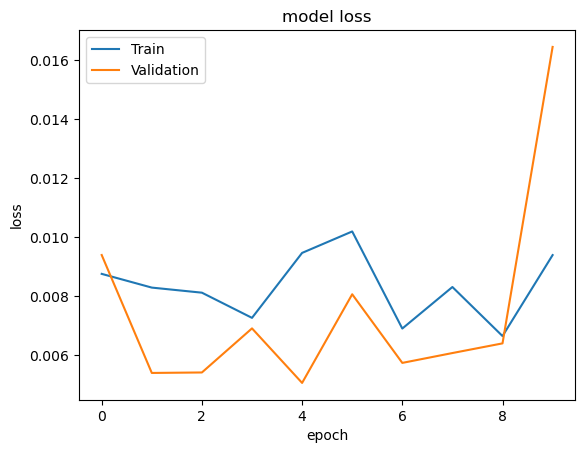

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()